# Pima Indians Diabetes Database

Goal: Predict the onset of diabetes based on diagnostic measures

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The data can be found at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Diabetes).

In [ ]:
# Takes some time 3-5 minutes
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
import findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("diabetes_logistic").getOrCreate()

In [ ]:
df = spark.read.csv("/content/diabetes.csv", inferSchema=True, header=True)

In [ ]:
print(f"There are {df.count()} rows and {len(df.columns)} columns in the dataset.")

There are 768 rows and 9 columns in the dataset.


In [ ]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 2 rows



In [ ]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



In [ ]:
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [ ]:
df.groupby("Outcome").count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



In [ ]:
import matplotlib.pyplot as plt

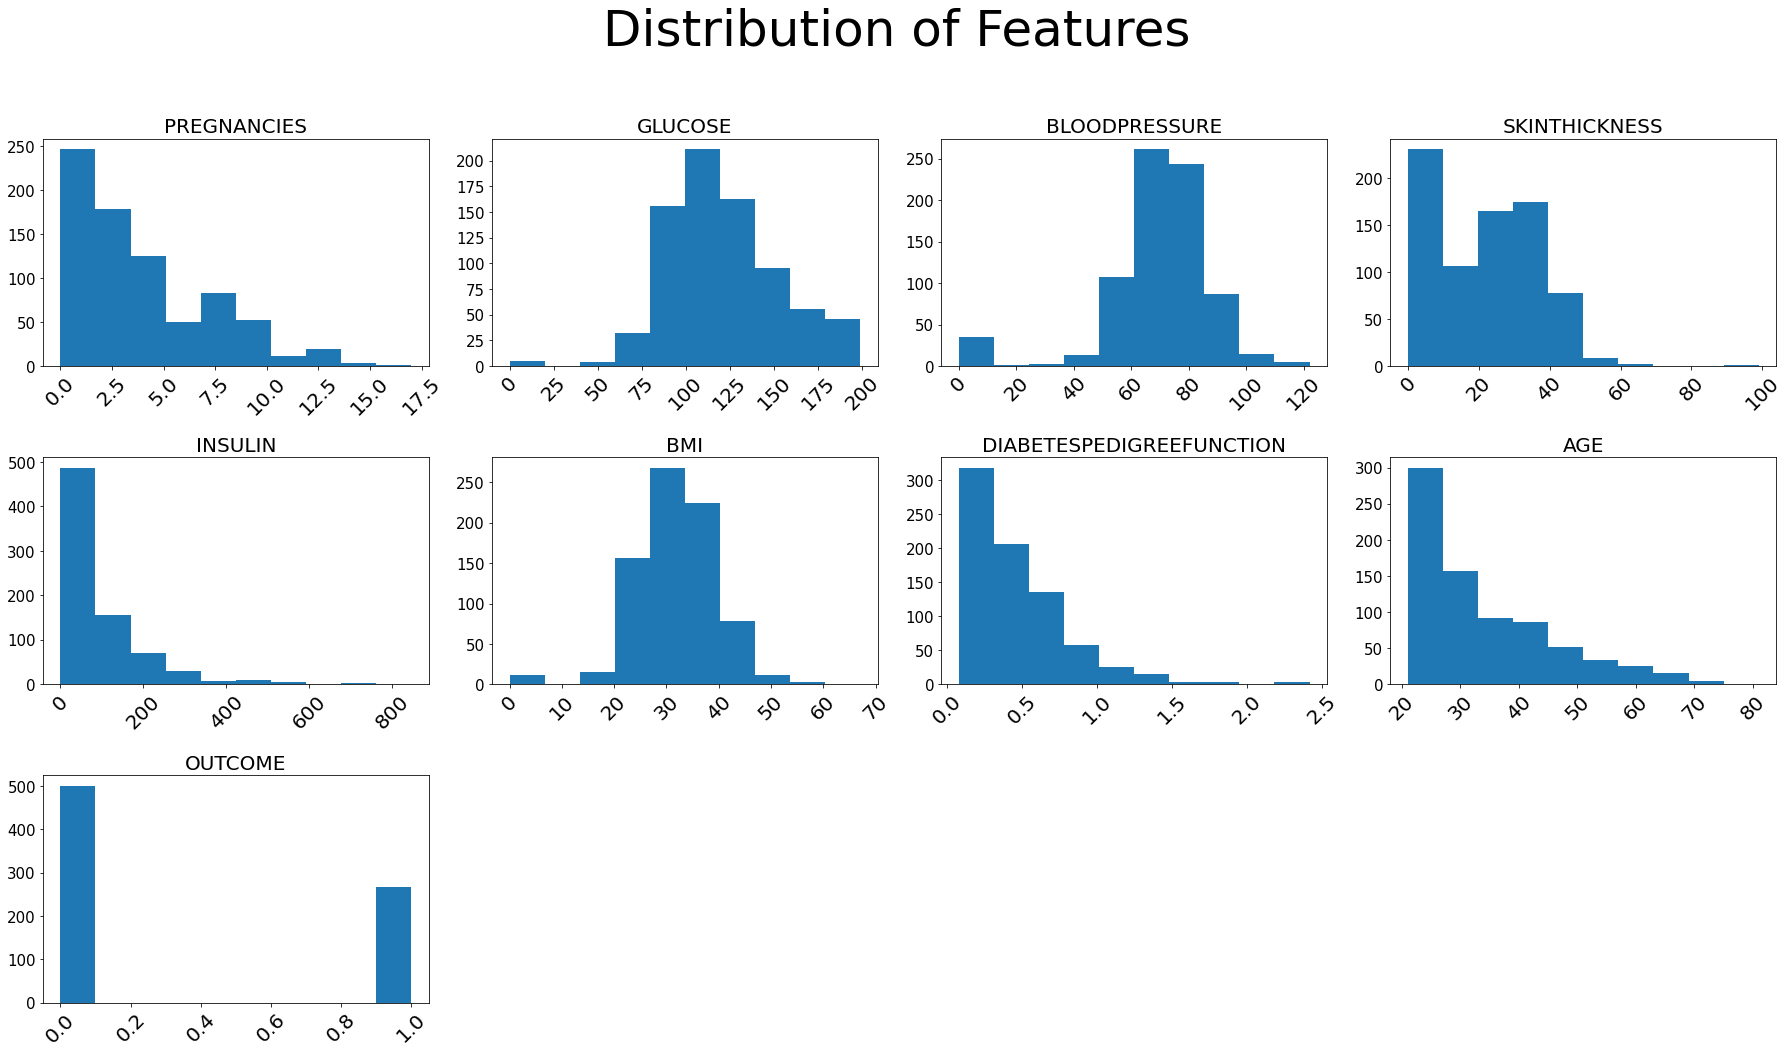

In [ ]:
fig = plt.figure(figsize=(25, 15))
st = fig.suptitle("Distribution of Features", fontsize=50, verticalalignment="center")

for col, num in zip(df.toPandas().describe().columns, range(1,11)):
  ax = fig.add_subplot(3, 4, num)
  ax.hist(df.toPandas()[col])
  plt.grid(False)
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=15)
  plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

In [ ]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


## User Defined Functions (UDF)

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [ ]:
y_udf = udf(lambda y: "no" if y==0 else "yes", StringType())

In [ ]:
df = df.withColumn("HasDiabetes", y_udf('Outcome')).drop("Outcome")

In [ ]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+
only showing top 2 rows



In [ ]:
def udf_multiple(age):
  if (age<=25):
    return "Under 25"
  elif (age >=25 and age <= 35):
    return "Between 25 and 35"
  elif (age > 35 and age < 50):
    return "Between 36 and 50"
  elif (age >= 50):
    return "Over 50"
  else: return "NA"

In [ ]:
age_udf = udf(udf_multiple)
df = df.withColumn('age_udf', age_udf('Age'))

In [ ]:
df.show(2)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|HasDiabetes|          age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|        yes|          Over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|         no|Between 25 and 35|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-----------+-----------------+
only showing top 2 rows



In [ ]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import rank, sum, col, desc
from pyspark.sql import Window

In [ ]:
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)
tab = df.select(['age_udf', 'Glucose']).\
    groupBy('age_udf').\
        agg(
            F.count('Glucose').alias('UserCount'),
            F.mean('Glucose').alias('Glucose_AVG'),
            F.min('Glucose').alias('Glucose_MIN'),
            F.max('Glucose').alias('Glucose_MAX')).\
        withColumn('total', sum(col('UserCount')).over(window)).\
        withColumn('Percent', col('UserCount')*100 / col('total')).\
        drop(col('total')).sort(desc('Percent'))

In [ ]:
tab.show()

+-----------------+---------+------------------+-----------+-----------+------------------+
|          age_udf|UserCount|       Glucose_AVG|Glucose_MIN|Glucose_MAX|           Percent|
+-----------------+---------+------------------+-----------+-----------+------------------+
|         Under 25|      267|110.71910112359551|          0|        199|         34.765625|
|Between 25 and 35|      231|121.67099567099567|         71|        198|         30.078125|
|Between 36 and 50|      181|125.74033149171271|          0|        197|23.567708333333332|
|          Over 50|       89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+---------+------------------+-----------+-----------+------------------+



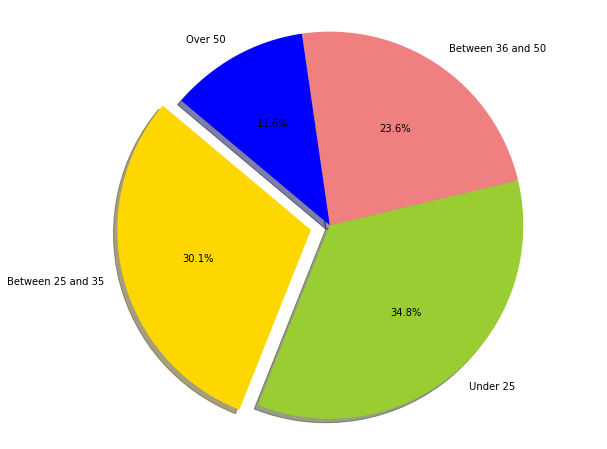

In [ ]:
labels = list(tab.select('age_udf').distinct().toPandas()['age_udf'])
sizes = list(tab.select('Percent').distinct().toPandas()['Percent'])
colors = ['gold','yellowgreen','lightcoral','blue','lightskyblue','green','red']
explode = (0.1, 0.0, 0.0, 0.0)

plt.figure(figsize=(10,8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# Pearson Correlation

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']
numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [ ]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [ ]:
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index = col_names
corr_df.columns = col_names
round(corr_df, 2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54
Glucose,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26
BloodPressure,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24
SkinThickness,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11
Insulin,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04
BMI,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03
Age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00


# Machine Learning Prep
1. StringIndexer
1. OneHotEncoderEstimator
1. VectorAssembler
1. LabelIndexer
1. StandardScaler

## Pipeline is the Future!@!@
Going to do this twice:
1. Manually
1. Pipeline

In [ ]:
from pyspark.ml.feature import StringIndexer

In [ ]:
stringIndexer = StringIndexer()\
                  .setInputCol("age_udf")\
                  .setOutputCol('age_udfindex')

In [ ]:
age_udf_indexer_model = stringIndexer.fit(df)
age_udf_index_df = age_udf_indexer_model.transform(df)
age_udf_index_df.toPandas()[['age_udf','age_udfindex']].head()

,age_udf,age_udfindex
0,Over 50,3.0
1,Between 25 and 35,1.0
2,Between 25 and 35,1.0
3,Under 25,0.0
4,Between 25 and 35,1.0


In [ ]:
from pyspark.ml.feature import OneHotEncoder

In [ ]:
encoder = OneHotEncoder()\
            .setInputCols(['age_udfindex'])\
            .setOutputCols(['age_encoded'])

In [ ]:
encoder_model = encoder.fit(age_udf_index_df)
encoder_df = encoder_model.transform(age_udf_index_df)
encoder_df.toPandas()[['age_udf','age_udfindex','age_encoded']].head()

,age_udf,age_udfindex,age_encoded
0,Over 50,3.0,"(0.0, 0.0, 0.0)"
1,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,Under 25,0.0,"(1.0, 0.0, 0.0)"
4,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [ ]:
encoder_df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'HasDiabetes',
 'age_udf',
 'age_udfindex',
 'age_encoded']

In [ ]:
assembler = VectorAssembler()\
              .setInputCols(['age_encoded', 'Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'SkinThickness',
                              'Insulin',
                              'BMI',
                              'DiabetesPedigreeFunction',])\
              .setOutputCol('vec_features')

In [ ]:
assembler_df = assembler.transform(encoder_df)

In [ ]:
assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HasDiabetes,age_udf,age_udfindex,age_encoded,vec_features
0,6,148,72,35,0,33.6,0.627,50,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 3..."
1,1,85,66,29,0,26.6,0.351,31,no,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26..."
2,8,183,64,0,0,23.3,0.672,32,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23..."
3,1,89,66,23,94,28.1,0.167,21,no,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 2..."
4,0,137,40,35,168,43.1,2.288,33,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0,..."


In [ ]:
label_indexer = StringIndexer()\
                  .setInputCol('HasDiabetes')\
                  .setOutputCol('label')

In [ ]:
label_indexer_model = label_indexer.fit(assembler_df)
label_indexer_df = label_indexer_model.transform(assembler_df)

In [ ]:
label_indexer_df.select('HasDiabetes','label').toPandas().head()

,HasDiabetes,label
0,yes,1.0
1,no,0.0
2,yes,1.0
3,no,0.0
4,yes,1.0


In [ ]:
from pyspark.ml.feature import StandardScaler

In [ ]:
scaler = StandardScaler()\
            .setInputCol('vec_features')\
            .setOutputCol('features')

In [ ]:
scaler_model = scaler.fit(label_indexer_df)
scaler_df=scaler_model.transform(label_indexer_df)

In [ ]:
pd.set_option('display.max_colwidth',100)
scaler_df.select('vec_features','features').toPandas().head()

,vec_features,features
0,"[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]","[0.0, 0.0, 0.0, 1.7806383732194306, 4.628960915766174, 3.7198138711154307, 2.1940523222807116, 0..."
1,"[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]","[0.0, 2.1791401333367157, 0.0, 0.29677306220323846, 2.658524850271114, 3.4098293818558116, 1.817..."
2,"[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]","[0.0, 2.1791401333367157, 0.0, 2.3741844976259077, 5.723647618818986, 3.306501218769272, 0.0, 0...."
3,"[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]","[2.098474993842542, 0.0, 0.0, 0.29677306220323846, 2.783631902048578, 3.4098293818558116, 1.4418..."
4,"[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]","[0.0, 2.1791401333367157, 0.0, 0.0, 4.284916523378148, 2.0665632617307947, 2.1940523222807116, 1..."


In [ ]:
from pyspark.ml import Pipeline

In [ ]:
pipeline_stages = Pipeline()\
                    .setStages([stringIndexer, 
                                encoder, 
                                assembler, 
                                label_indexer, 
                                scaler])

In [ ]:
pipeline_model = pipeline_stages.fit(df)

In [ ]:
pipeline_df = pipeline_model.transform(df)

In [ ]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,HasDiabetes,age_udf,age_udfindex,age_encoded,vec_features,label,features
0,6,148,72,35,0,33.6,0.627,50,yes,Over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]",1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, 4.628960915766174, 3.7198138711154307, 2.1940523222807116, 0..."
1,1,85,66,29,0,26.6,0.351,31,no,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]",0.0,"[0.0, 2.1791401333367157, 0.0, 0.29677306220323846, 2.658524850271114, 3.4098293818558116, 1.817..."
2,8,183,64,0,0,23.3,0.672,32,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]",1.0,"[0.0, 2.1791401333367157, 0.0, 2.3741844976259077, 5.723647618818986, 3.306501218769272, 0.0, 0...."
3,1,89,66,23,94,28.1,0.167,21,no,Under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]",0.0,"[2.098474993842542, 0.0, 0.0, 0.29677306220323846, 2.783631902048578, 3.4098293818558116, 1.4418..."
4,0,137,40,35,168,43.1,2.288,33,yes,Between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]",1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, 4.284916523378148, 2.0665632617307947, 2.1940523222807116, 1..."


# Pipline the Easy Way

In [ ]:
categoricalColumns = ['age_udf']
numericalColumns = ['Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'SkinThickness',
                              'Insulin',
                              'BMI',
                              'DiabetesPedigreeFunction']
stages = []
for categoricalCol in categoricalColumns:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+'_index')
  encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol+"_class_vec"])
  stages += [stringIndexer, encoder]

label_string_indexer = StringIndexer(inputCol='HasDiabetes', outputCol='label')
stages += [label_string_indexer]
assemblerInputs = [c + '_class_vec' for c in categoricalColumns] + numericalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='vec_features')
stages += [assembler]
scaler = StandardScaler(inputCol='vec_features',outputCol='features')
stages += [scaler]


In [ ]:
cols = df.columns
pipeline = Pipeline(stages=stages)
df_pipe = pipeline.fit(df).transform(df)
selectedCols = ['label','features'] + cols 
df2 = df_pipe.select(selectedCols)
df2.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- HasDiabetes: string (nullable = true)
 |-- age_udf: string (nullable = true)



# Train/Test Split

In [ ]:
print(f"There are {df2.count()} records in total. Split the data into training and test sets (20% held out for testing)")

There are 768 records in total. Split the data into training and test sets (20% held out for testing)


In [ ]:
train, test = df2.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Size: {train.count()}")
print(f"Test Data Size: {test.count()}")

Training Data Size: 645
Test Data Size: 123


In [ ]:
train.groupby('HasDiabetes').count().show()

+-----------+-----+
|HasDiabetes|count|
+-----------+-----+
|         no|  426|
|        yes|  219|
+-----------+-----+



# Model Training
- Logistic Regression
- Since it's a classification problem {Predict: HasDiabetes}

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter=5)
model = lr.fit(train)
pred = model.transform(test)
pred.select('label','features', 'rawPrediction','prediction','probability').toPandas().head()

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.098474993842542, 0.0, 0.0, 0.5935461244064769, 2.314480457883087, 0.0, 0.0, 0.0, 0.0, 0.30785...","[1.5895743412837708, -1.5895743412837708]",0.0,"[0.8305562074392718, 0.16944379256072817]"
1,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3.1902298203253365, 3.8748061157452405, 1.4418058117844677, 0...","[2.949631266148634, -2.949631266148634]",0.0,"[0.950246058156793, 0.04975394184320703]"
2,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3.1589530573809705, 3.2031730556827323, 0.0, 0.0, 2.777721293...","[2.315629444649308, -2.315629444649308]",0.0,"[0.9101632172916176, 0.08983678270838236]"
3,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 4.1285327086563175, 4.02979836037505, 0.0, 0.0, 4.10950547470...","[1.9303354598954814, -1.9303354598954814]",0.0,"[0.8732865455641057, 0.12671345443589432]"
4,0.0,"(0.0, 2.1791401333367157, 0.0, 1.7806383732194306, 3.00256924265914, 0.0, 0.0, 0.0, 3.0060271527...","[-0.49591320139500716, 0.49591320139500716]",1.0,"[0.37850156119851913, 0.6214984388014808]"


# Model Evaluation

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
eval = BinaryClassificationEvaluator()

In [ ]:
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.832873690016547


# Model Accruary

In [ ]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())

In [ ]:
print(f"Accuracy: {acc}")

Accuracy: 0.7886178861788617


In [ ]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]) # regularization parameter
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) # Elastic Net Param (Ridge=0, Lasso=1)
    .addGrid(lr.maxIter, [1,5,10, 20]) # Max Iterations?
    .build()
)
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=eval, numFolds=5)

cv_model = cv.fit(train)


KeyboardInterrupt: ignored

In [ ]:
# Best Model Performance
pred = cv_model.transform(test)
print(f"Test Area Under ROC: {eval.evaluate(pred)}")

Test Area Under ROC: 0.8314947600661884


In [ ]:
acc = pred.filter(pred.label == pred.prediction).count() / float(pred.count())
print(f"Accuracy: {acc}")

Accuracy: 0.7317073170731707


# Best Model Feature Weights

In [ ]:
df2.columns

['label',
 'features',
 'Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'HasDiabetes',
 'age_udf']

In [ ]:
weights = cv_model.bestModel.coefficients
weights = [(float(w), ) for w in weights]
weights_df = spark.createDataFrame(weights, ['Feature Weight'])
weights_df.toPandas().head(10) 

,Feature Weight
0,-0.256450
1,-0.011061
2,0.104444
3,0.248259
4,0.818539
5,-0.032937
6,-0.037487
7,0.008873
8,0.432523
9,0.320956


# Best Model Parameters

In [ ]:
best_model = cv_model.bestModel

In [ ]:
best = f"""
Best Model Parameters
=============================
regParam:\t{best_model._java_obj.getRegParam()}
MaxIter:\t{best_model._java_obj.getMaxIter()}
elasticNet:\t{best_model._java_obj.getElasticNetParam()}
"""

In [ ]:
print(best)


Best Model Parameters
regParam:	0.05
MaxIter:	20
elasticNet:	0.0

